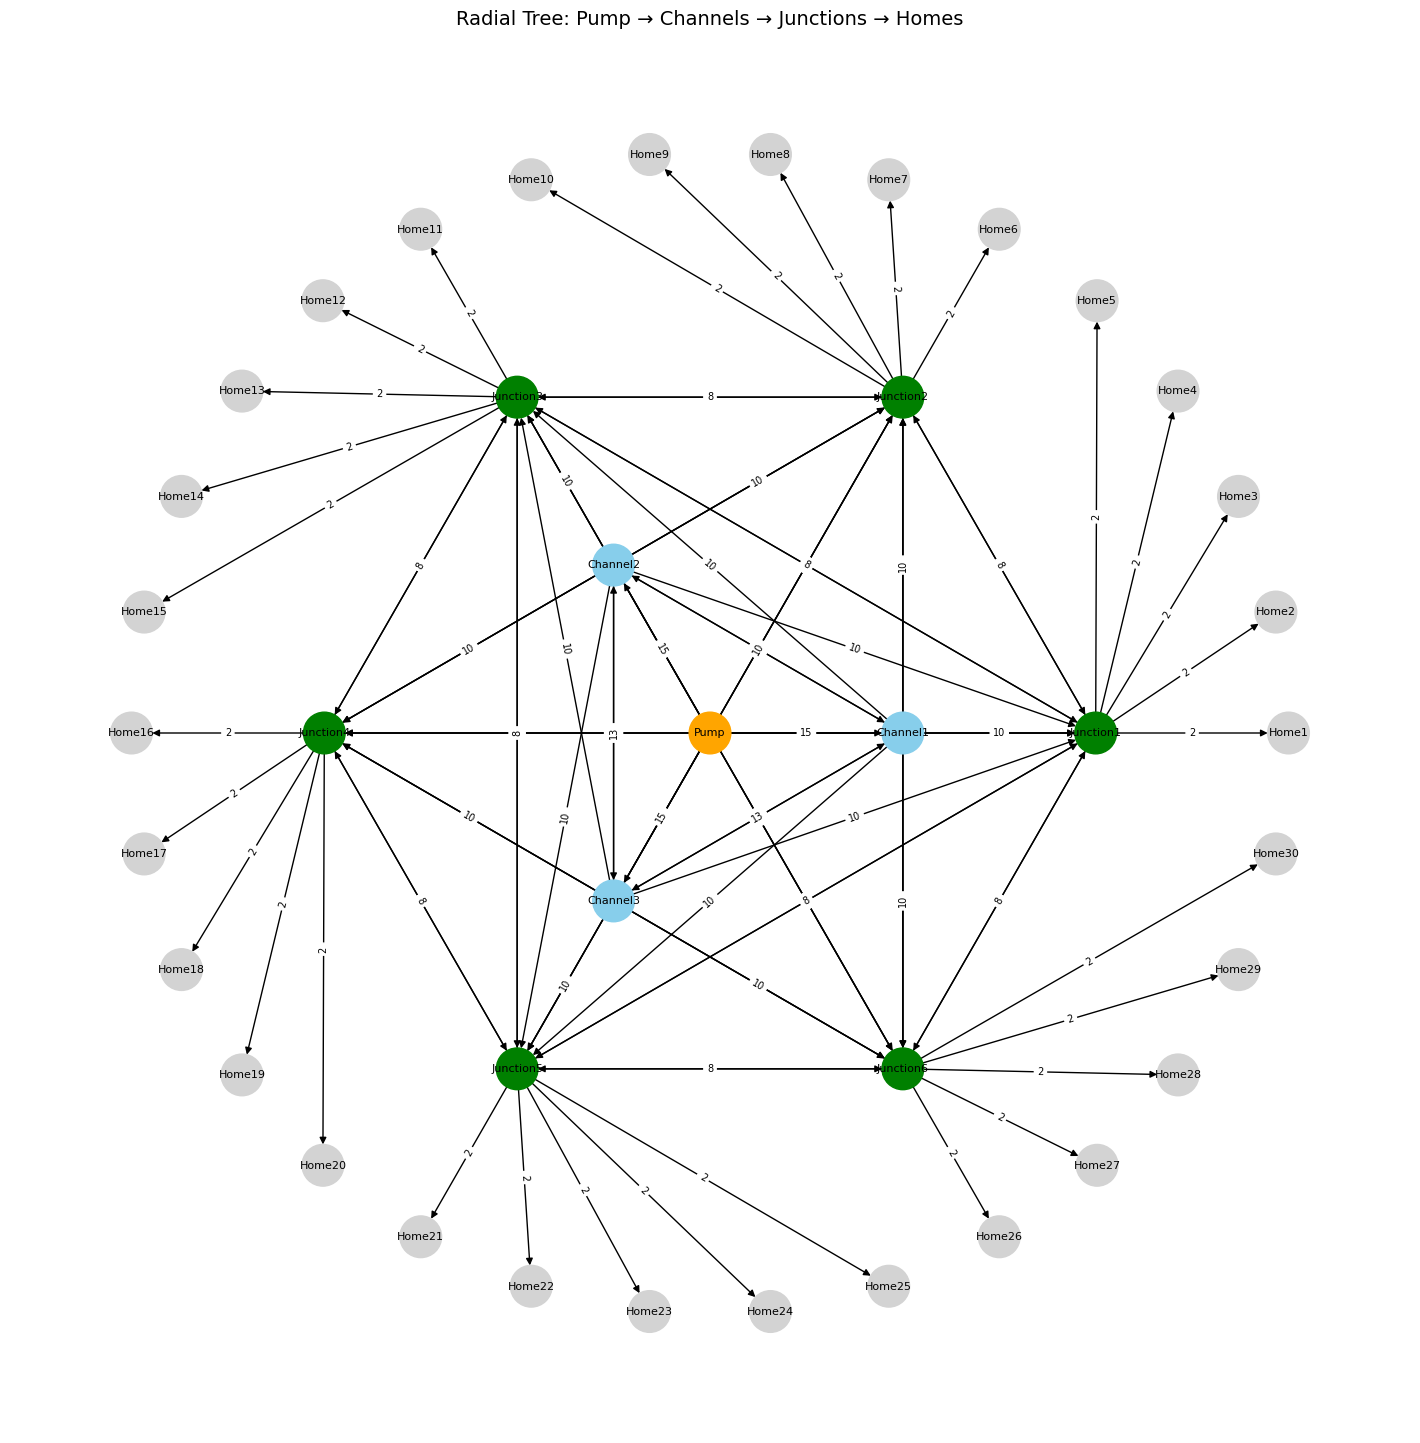

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define node groups
pump = "Pump"
channels = ["Channel1", "Channel2", "Channel3"]
junctions = [f"Junction{i}" for i in range(1, 7)]
homes = [f"Home{i}" for i in range(1, 31)]

# Create directed graph
G = nx.DiGraph()

# Add edges
for ch in channels:
    G.add_edge(pump, ch, weight=15)
    for jn in junctions:
        G.add_edge(ch, jn, weight=10)

# Fully connect channels and junctions with each other
for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        G.add_edge(channels[i], channels[j], weight=13)
        G.add_edge(channels[j], channels[i], weight=13)

for i in range(len(junctions)):
    for j in range(i + 1, len(junctions)):
        G.add_edge(junctions[i], junctions[j], weight=8)
        G.add_edge(junctions[j], junctions[i], weight=8)

# Connect junctions to homes (5 homes per junction)
junction_to_homes = {
    junctions[i]: homes[i * 5:(i + 1) * 5] for i in range(6)
}
for jn, hs in junction_to_homes.items():
    for h in hs:
        G.add_edge(jn, h, weight=2)

# ==============================
# Position nodes in radial rings
# ==============================
def circular_positions(center, radius, nodes):
    angle_gap = 2 * np.pi / len(nodes)
    positions = {}
    for i, node in enumerate(nodes):
        angle = i * angle_gap
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        positions[node] = (x, y)
    return positions

center = (0, 0)
pos = {}
pos[pump] = center

# Create radial layers
pos.update(circular_positions(center, 2, channels))
pos.update(circular_positions(center, 4, junctions))
pos.update(circular_positions(center, 6, homes))

# ==================
# Draw the graph
# ==================
# Node color mapping
node_colors = []
for node in G.nodes():
    if node == "Pump":
        node_colors.append("orange")
    elif "Channel" in node:
        node_colors.append("skyblue")
    elif "Junction" in node:
        node_colors.append("green")
    else:
        node_colors.append("lightgray")

plt.figure(figsize=(14, 14))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=900, font_size=8, arrows=True)

# Draw edge weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Radial Tree: Pump → Channels → Junctions → Homes", fontsize=14)
plt.axis('off')
plt.show()


```markdown
# Water Distribution Network Simulation and Resilience

This notebook demonstrates a simulation of a water distribution network using the `networkx` library in Python. It covers the following aspects:

1.  **Graph Construction**: A directed graph representing a water network is built, connecting a central `Pump` to `Channels`, `Junctions`, and finally to individual `Homes`. Each connection (edge) is assigned a `weight`.

2.  **Radial Layout**: Node positions are calculated to create a visually intuitive radial layout, with the pump at the center, followed by concentric rings of channels, junctions, and homes.

3.  **Failure Simulation**: The notebook simulates a failure in the network by removing a specific `Junction` (e.g., 'Junction3'). This highlights the direct impact on homes connected to the failed junction.

4.  **Resilience - Reconnection Strategy**: To demonstrate network resilience, a strategy is implemented to reconnect homes that were affected by the junction failure. It uses Dijkstra's algorithm to find the best alternate junction (with the lowest cost path from the pump) for each affected home and re-establishes connections.

## Components of the Network:

*   **Pump**: The source of water.
*   **Channels**: Distribute water from the pump to junctions.
*   **Junctions**: Connect channels to homes and can also connect to other channels/junctions.
*   **Homes**: The end-users of the water supply.

## Visualization:

The notebook uses `matplotlib` to visualize the network at different stages:

*   **Initial Network**: Shows the complete network with node and edge labels.
*   **Network After Failure**: Illustrates the impact of a junction failure, with affected homes potentially highlighted.
*   **Reconnected Network**: Displays the network after affected homes have been reconnected to alternative junctions, with new connections highlighted.

This simulation provides a basic framework for understanding network topology, fault tolerance, and potential recovery mechanisms in infrastructure systems.
```

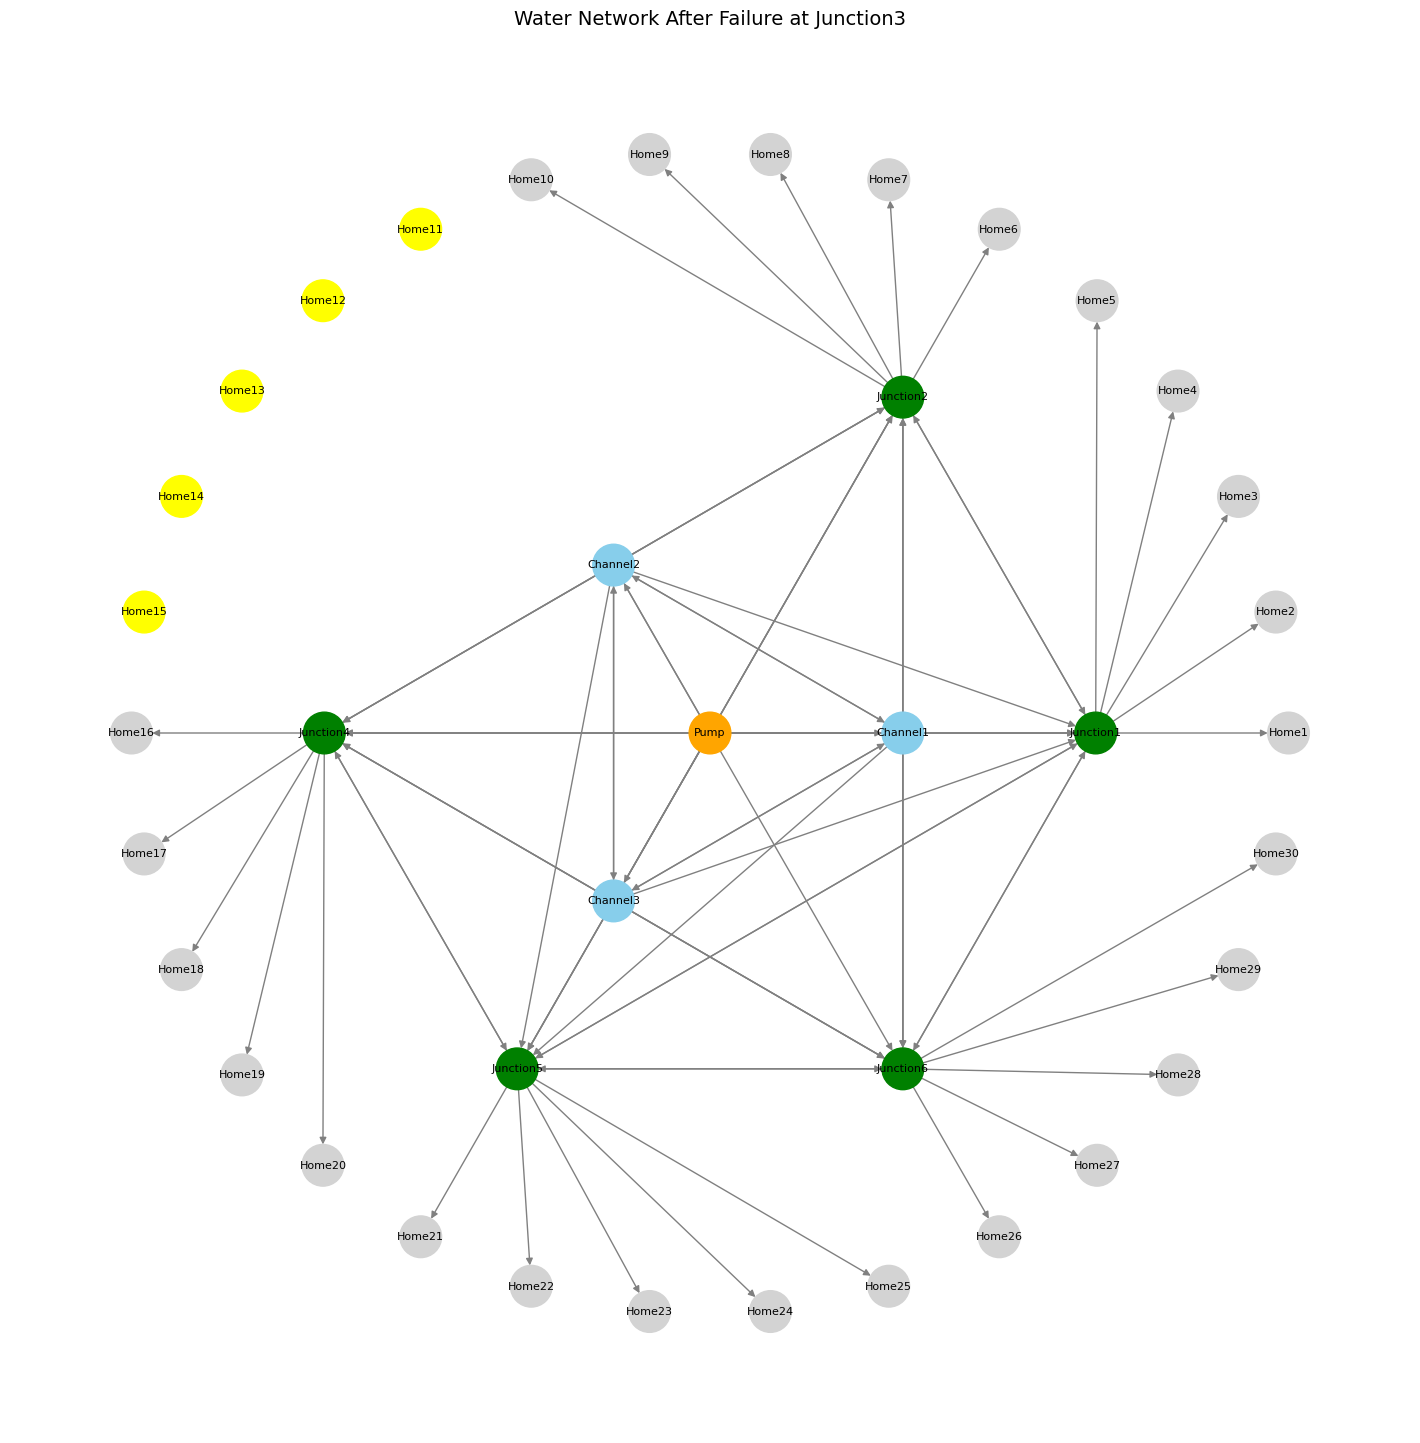

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Build Original Graph
# ==========================
pump = "Pump"
channels = ["Channel1", "Channel2", "Channel3"]
junctions = [f"Junction{i}" for i in range(1, 7)]
homes = [f"Home{i}" for i in range(1, 31)]

G = nx.DiGraph()

# Add connections
for ch in channels:
    G.add_edge(pump, ch, weight=15)
    for jn in junctions:
        G.add_edge(ch, jn, weight=10)

for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        G.add_edge(channels[i], channels[j], weight=13)
        G.add_edge(channels[j], channels[i], weight=13)

for i in range(len(junctions)):
    for j in range(i + 1, len(junctions)):
        G.add_edge(junctions[i], junctions[j], weight=8)
        G.add_edge(junctions[j], junctions[i], weight=8)

junction_to_homes = {
    junctions[i]: homes[i * 5:(i + 1) * 5] for i in range(6)
}
for jn, hs in junction_to_homes.items():
    for h in hs:
        G.add_edge(jn, h, weight=2)

# ==========================
# 2. Layout Positions
# ==========================
def circular_positions(center, radius, nodes):
    angle_gap = 2 * np.pi / len(nodes)
    positions = {}
    for i, node in enumerate(nodes):
        angle = i * angle_gap
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        positions[node] = (x, y)
    return positions

center = (0, 0)
pos = {}
pos[pump] = center
pos.update(circular_positions(center, 2, channels))
pos.update(circular_positions(center, 4, junctions))
pos.update(circular_positions(center, 6, homes))

# ==========================
# 3. Simulate Failure
# ==========================
failed_junction = "Junction3"
affected_homes = junction_to_homes[failed_junction]

G_failure = G.copy()
G_failure.remove_node(failed_junction)

# ==========================
# 4. Color Mapping
# ==========================
node_colors = []
for node in G_failure.nodes():
    if node == pump:
        node_colors.append("orange")
    elif "Channel" in node:
        node_colors.append("skyblue")
    elif "Junction" in node:
        node_colors.append("green")
    elif node in affected_homes:
        node_colors.append("yellow")
    else:
        node_colors.append("lightgray")

# Edge color mapping (optional: color broken edges red)
edge_colors = []
for u, v in G_failure.edges():
    if u == failed_junction or v == failed_junction:
        edge_colors.append("red")
    else:
        edge_colors.append("gray")

# ==========================
# 5. Draw Graph
# ==========================
plt.figure(figsize=(14, 14))
nx.draw(
    G_failure, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=900, font_size=8,
    arrows=True
)
plt.title(f"Water Network After Failure at {failed_junction}", fontsize=14)
plt.axis('off')
plt.show()


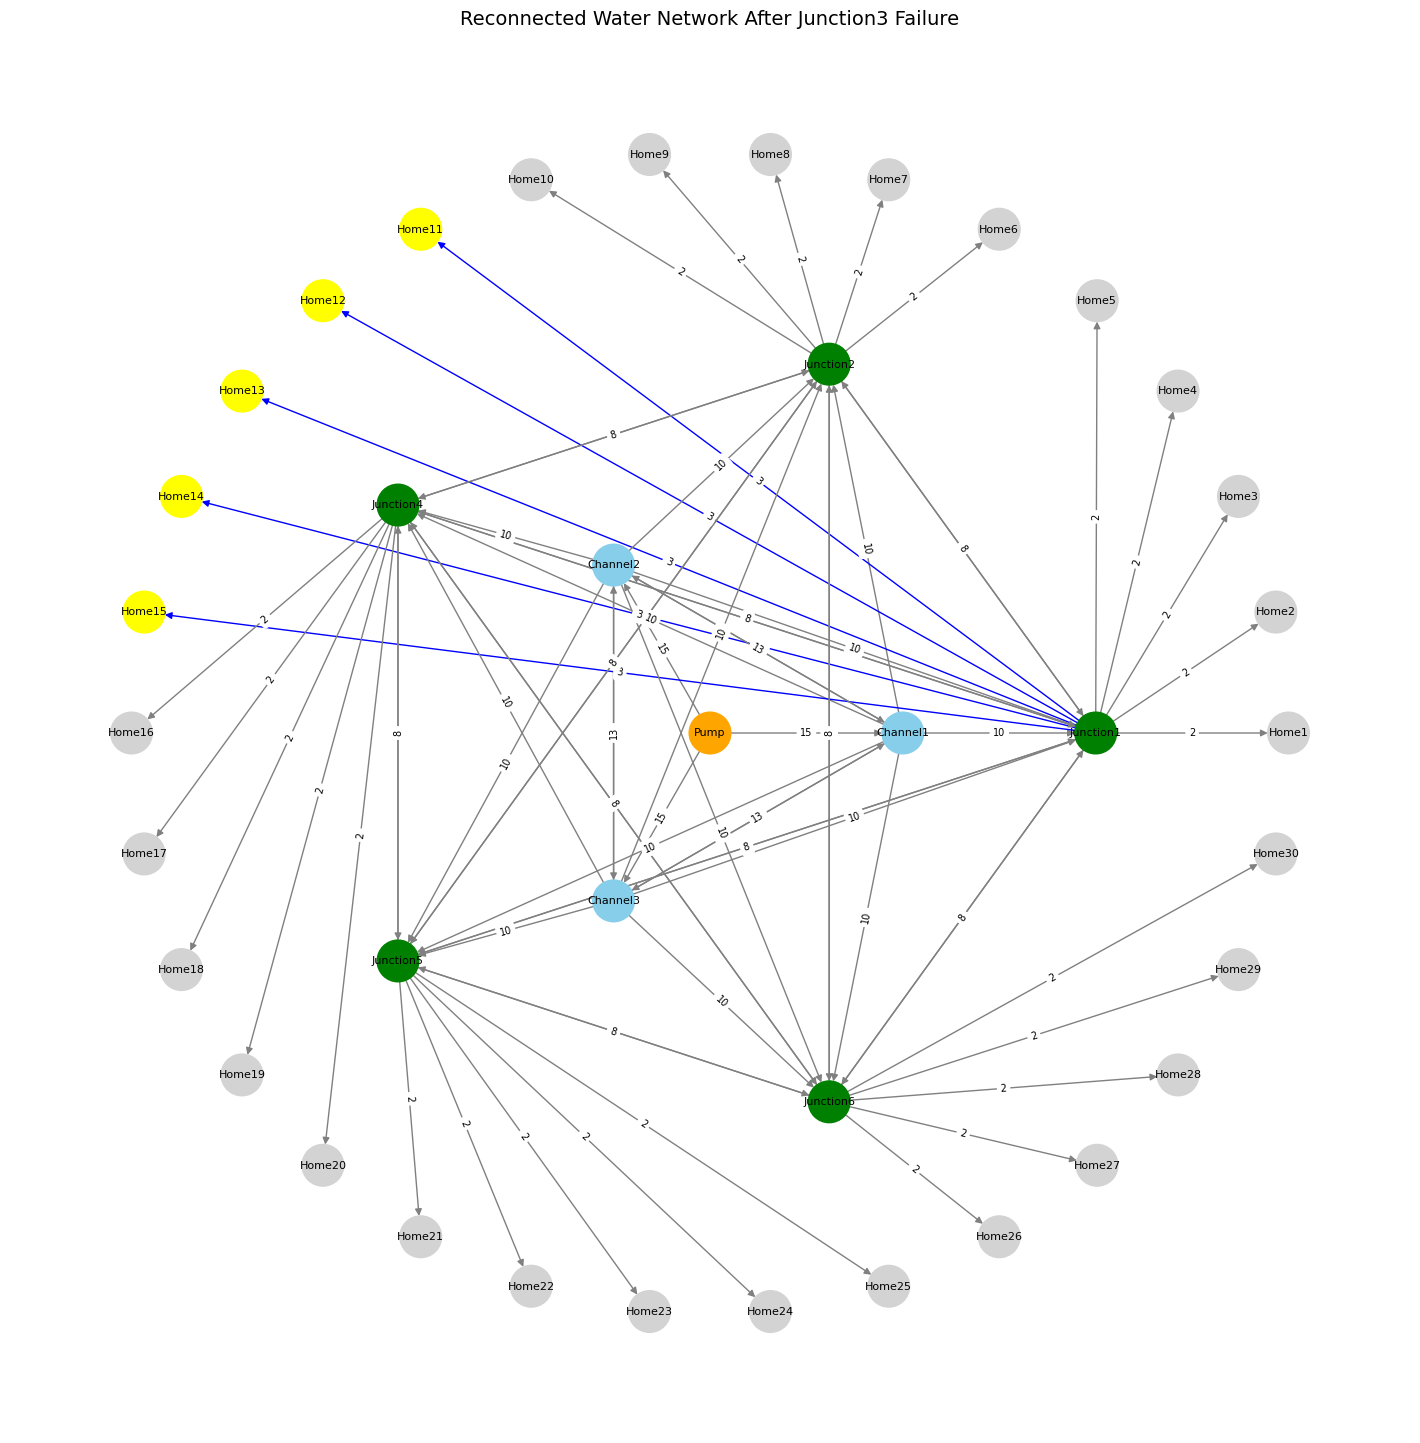

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# =====================
# 1. Original Setup
# =====================
pump = "Pump"
channels = ["Channel1", "Channel2", "Channel3"]
junctions = [f"Junction{i}" for i in range(1, 7)]
homes = [f"Home{i}" for i in range(1, 31)]

G = nx.DiGraph()

# Build base graph
for ch in channels:
    G.add_edge(pump, ch, weight=15)
    for jn in junctions:
        G.add_edge(ch, jn, weight=10)

for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        G.add_edge(channels[i], channels[j], weight=13)
        G.add_edge(channels[j], channels[i], weight=13)

for i in range(len(junctions)):
    for j in range(i + 1, len(junctions)):
        G.add_edge(junctions[i], junctions[j], weight=8)
        G.add_edge(junctions[j], junctions[i], weight=8)

junction_to_homes = {
    junctions[i]: homes[i * 5:(i + 1) * 5] for i in range(6)
}
for jn, hs in junction_to_homes.items():
    for h in hs:
        G.add_edge(jn, h, weight=2)

# =====================
# 2. Simulate Failure
# =====================
failed_junction = "Junction3"
affected_homes = junction_to_homes[failed_junction]
G_failure = G.copy()
G_failure.remove_node(failed_junction)

# =====================
# 3. Reconnect Affected Homes (11–15)
# =====================
# Use Dijkstra to find best alternate junctions
alternate_junctions = [j for j in junctions if j != failed_junction]

# Find best junction for each affected home based on lowest cost
reconnected_edges = []
for home in affected_homes:
    min_cost = float("inf")
    best_junction = None
    for jn in alternate_junctions:
        try:
            cost = nx.dijkstra_path_length(G_failure, pump, jn)
            if cost < min_cost:
                min_cost = cost
                best_junction = jn
        except nx.NetworkXNoPath:
            continue
    if best_junction:
        G_failure.add_edge(best_junction, home, weight=3)
        reconnected_edges.append((best_junction, home))

# =====================
# 4. Positions for Drawing
# =====================
def circular_positions(center, radius, nodes):
    angle_gap = 2 * np.pi / len(nodes)
    positions = {}
    for i, node in enumerate(nodes):
        angle = i * angle_gap
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        positions[node] = (x, y)
    return positions

center = (0, 0)
pos = {}
pos[pump] = center
pos.update(circular_positions(center, 2, channels))
pos.update(circular_positions(center, 4, [j for j in junctions if j != failed_junction]))
pos.update(circular_positions(center, 6, homes))

# =====================
# 5. Node & Edge Coloring
# =====================
node_colors = []
for node in G_failure.nodes():
    if node == pump:
        node_colors.append("orange")
    elif "Channel" in node:
        node_colors.append("skyblue")
    elif "Junction" in node:
        node_colors.append("green")
    elif node in affected_homes:
        node_colors.append("yellow")
    else:
        node_colors.append("lightgray")

edge_colors = []
for edge in G_failure.edges():
    if edge in reconnected_edges:
        edge_colors.append("blue")
    else:
        edge_colors.append("gray")

# =====================
# 6. Draw Updated Graph
# =====================
plt.figure(figsize=(14, 14))
nx.draw(
    G_failure, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=900, font_size=8,
    arrows=True
)

edge_labels = nx.get_edge_attributes(G_failure, 'weight')
nx.draw_networkx_edge_labels(G_failure, pos, edge_labels=edge_labels, font_size=7)

plt.title("Reconnected Water Network After Junction3 Failure", fontsize=14)
plt.axis('off')
plt.show()
